<h1 align="center">AIND-CNC Spring Hackathon</h1>  
<h4 align="center"> May 14, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** This notebook shows how to access and analyze data from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) project established at the Allen Institute for Neural Dynamics. 

**Dataset:** Calcium activity was recorded from hundreds of cortical neurons in the mouse brain while the animal learned and performed a Brain Computer Interface (BCI) task over several days. 
    
**Goal:** This tutorial will show you how to:  
    1. load and work with neuronal calcium activity data processed via suite2p 
    2. plot event-aligned neural activity traces 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [1]:
# general imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 

# pynwb imports to open nwb files
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

In [29]:
# nwb_file = '/data/nwb/single-plane-ophys_767715_2025-02-17_17-41-50_behavior_nwb'
nwb_file = '/data/single-plane-ophys_731015_2025-01-28_17-40-57_processed_2025-05-03_18-17-54/single-plane-ophys_731015_2025-01-28_17-40-57_behavior_nwb'
# nwb_file = '/data/nwb_2/single-plane-ophys_767715_2025-02-17_17-41-50_behavior_nwb'
with NWBZarrIO(nwb_file, "r") as io:
    nwbfile_read = io.read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [30]:
nwb2widget(nwbfile_read) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### 1. Plot Calcium Activity Traces for Select ROIs 
    
The raw data was processed through Suite2p, which extracts the cell body ROIs and calculates the change in fluorescence (dff). Let's pull that data from the nwb file below. The shape of roi_dff is (frames, roi). 
    
We'll also save the frame_rate so we can easily convert from frames to seconds. 
    

In [38]:
roi_dff = nwbfile_read.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('roi_dff shape:',np.shape(roi_dff))

frame_rate = nwbfile_read.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].rate
print('Frame Rate:', frame_rate)

roi_dff shape: (226322, 373)
Frame Rate: 58.2634


In [37]:
nwbfile_read.stimulus

dff pynwb.ophys.RoiResponseSeries at 0x139918304430544
Fields:
  comments: no comments
  conversion: 1.0
  data: <zarr.core.Array '/processing/processed/dff/dff/data' (226322, 373) float32 read-only>
  description: no description
  offset: 0.0
  rate: 58.2634
  resolution: -1.0
  rois: rois <class 'hdmf.common.table.DynamicTableRegion'>
  starting_time: 0.0
  starting_time_unit: seconds
  unit: %

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The roi_dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons (pre) - spont_slm * 
    2. Spontaneous activity (pre) - spont *
    3. BCI behavior task - BCI 
    4. Spontaneous activity (post) - spontpost * 
    5. Photostimulation of random single neurons (post) -spontpost_slm * 
    

The stimulus tables in the stimulus>PhotostimTrials and the behavior table in the intervals>trials containers contains the start/stop times for each epoch. 

*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

In [6]:
# Get the epoch time periods from the nwb file 

# Convert the hdmf to Pandas DataFrame 
photostim_table = nwbfile_read.stimulus["PhotostimTrials"].to_dataframe()
photostim_table


,start_time,stop_time,start_frame,stop_frame,tiff_file,stim_name,laser_stim_x,laser_stim_y,power,duration,stimulus_function,group_index
id,,,,,,,,,,,,
0,0.000000,4.376676,0,255,spont_slm_00001.tif,photostim,107.169492,206.220339,4,4.376676,scanimage.mroi.stimulusfunctions.logspiral,14
1,4.393839,5.509462,256,321,spont_slm_00002.tif,photostim,339.576271,228.881356,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,1
2,5.526626,6.659412,322,388,spont_slm_00003.tif,photostim,133.711538,38.480769,4,1.132787,scanimage.mroi.stimulusfunctions.logspiral,5
3,6.676576,7.792199,389,454,spont_slm_00004.tif,photostim,115.289474,220.815789,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,6
4,7.809362,8.959312,455,522,spont_slm_00005.tif,photostim,58.403226,197.983871,4,1.149950,scanimage.mroi.stimulusfunctions.logspiral,25
...,...,...,...,...,...,...,...,...,...,...,...,...
2006,3872.980293,3874.095916,225653,225718,spontpost_slm_01004.tif,photostim_post,297.627451,134.784314,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,39
2007,3874.113080,3875.228703,225719,225784,spontpost_slm_01005.tif,photostim_post,94.000000,49.840000,4,1.115623,scanimage.mroi.stimulusfunctions.logspiral,41
2008,3875.245866,3876.344326,225785,225849,spontpost_slm_01006.tif,photostim_post,199.621622,106.972973,4,1.098460,scanimage.mroi.stimulusfunctions.logspiral,34


In [39]:
256/58.26

4.394095434260213

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation periods - one before and one after the BCI behavior sessions. 

In [7]:
photostim_table.stim_name.unique().tolist()

['photostim', 'photostim_post']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's grab the frame ranges for each photostimulation session. 

In [11]:
photostim_start = photostim_table[photostim_table.stim_name == 'photostim'].start_frame.tolist()[0]
photostim_stop = photostim_table[photostim_table.stim_name == 'photostim'].stop_frame.tolist()[-1]

photostim_post_start = photostim_table[photostim_table.stim_name == 'photostim_post'].start_frame.tolist()[0]
photostim_post_stop = photostim_table[photostim_table.stim_name == 'photostim_post'].stop_frame.tolist()[-1]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The BCI behavior information is stored in the trials table of the intervals container. Let's walk through the organization of the table and grab the time ranges for the behavior session.  

In [21]:
behavior_table = nwbfile_read.trials.to_dataframe()
behavior_table

# note the BCI behavior times are relative to start of each trial 

,start_time,stop_time,BCI_go_cue,BCI_trial_hit,BCI_lick_L,BCI_reward_time,BCI_threshold_crossing_times,BCI_zaber_steps,BCI_movie_name,BCI_start_frame,BCI_stop_frame
id,,,,,,,,,,,
0,1958.635119,1966.103904,0.2359,True,"[3.6621, 4.1976, 4.3578, 4.5215000000000005, 4...",4.3578,4.2950,"[1.7951, 2.5971, 2.6791, 2.7561, 2.82610000000...",neuron197_00001.tif,84824,85318
1,1967.138626,1971.496348,0.2359,True,"[0.0007, 2.2212, 2.3379000000000003, 2.463, 2....",2.2212,2.1027,"[0.3816, 0.6436000000000001, 1.4815, 1.5535, 1...",neuron197_00002.tif,85319,85632
2,1972.524239,1978.042755,0.2359,True,"[3.3823000000000003, 3.5058, 3.6198, 3.7278, 3...",3.3823,3.2832,"[0.8621000000000001, 1.9271, 2.217100000000000...",neuron197_00003.tif,85633,86012
3,1979.065033,1983.093325,0.2359,True,"[1.892, 2.0313, 2.156, 2.2602, 2.3771, 2.4938,...",1.8920,1.7679,"[0.287, 0.625, 0.745, 0.861, 0.9429, 1.025, 1....",neuron197_00004.tif,86013,86306
4,1984.124270,1988.078693,0.2359,True,"[1.2872, 1.4195, 1.5324, 1.6468, 1.76860000000...",1.2872,1.2062,"[0.5345, 0.7795000000000001, 0.8495, 0.8825000...",neuron197_00005.tif,86307,86597
...,...,...,...,...,...,...,...,...,...,...,...
94,2964.440614,2977.468724,0.2359,True,"[6.8048, 6.9987, 7.1363, 7.2678, 7.44750000000...",7.6392,7.5676,"[0.2871, 1.087, 1.6700000000000002, 2.2479, 2....",neuron197_00095.tif,143335,144152
95,2978.515074,2989.537600,0.2359,True,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[0.2878, 0.8768, 2.4487, 3.0577, 3.7786, 4.545...",neuron197_00096.tif,144153,144854
96,2990.575984,3001.598831,0.2359,True,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[0.2871, 1.6860000000000002, 5.874800000000000...",neuron197_00097.tif,144855,145555


In [13]:
behavior_start = behavior_table.BCI_start_frame.tolist()[0]
behavior_stop = behavior_table.BCI_stop_frame.tolist()[-1]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now, let's plot the calcium activity trace for a selected ROI, with the different stimulus epochs overlaid. 

NOTE - the timing for the epochs here is wrong, waiting for the latest NWB file with correct times

Text(0, 0.5, '$\\Delta$ F/F')

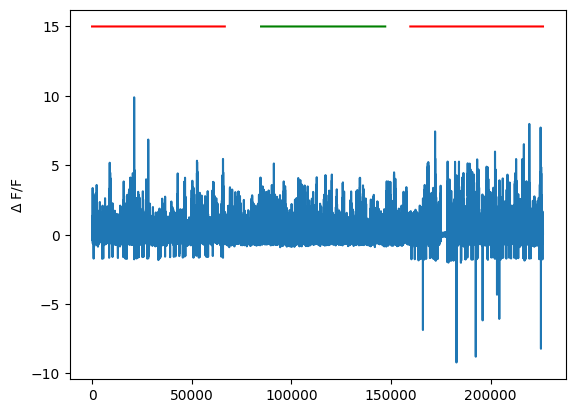

In [20]:
# Plot calcium activity trace for select ROIs 

ROI = 1 

#Plot DFF 
plt.plot(roi_dff[:,ROI])
# Plot first photostim period 
plt.plot(range(photostim_start, photostim_stop), np.ones(photostim_stop - photostim_start)*15, 'r')
# Plot behavior period 
plt.plot(range(behavior_start, behavior_stop), np.ones(behavior_stop - behavior_start)*15, 'g')
# Plot second photostim period 
plt.plot(range(photostim_post_start, photostim_post_stop), np.ones(photostim_post_stop - photostim_post_start)*15, 'r')
plt.ylabel('$\Delta$ F/F')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Each row in roi_dff represents an ROI extracted using suite2p then classified as either a soma or a dendrite. 

In [22]:
image_segmentation = nwbfile_read.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,1,0.989756,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.801911,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,0.991564,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,0.999997,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0.000000,0,0.002915,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
368,1,0.999999,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
369,0,0.000560,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
370,1,0.999997,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


to do 
- recreate the image mask representation from the image_mask columns and then highlight the ROIs of interest... 
- working on optimizing the visualization of image masks... 

maybe put this side-by-side with the calcium activity trace data? 

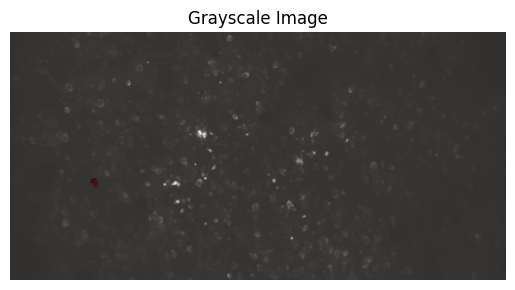

In [23]:
image_data = nwbfile_read.processing["processed"].data_interfaces["images"]["average_projection"]

# Display the image
plt.imshow(image_data.data[:], cmap='gray')
# Convert this to a contour instead of imshow for better visualization 
plt.imshow(image_segmentation.image_mask[200], cmap='Reds', alpha = 0.2)  # Use alpha for transparency
plt.axis('off')
plt.title('Grayscale Image')
plt.show()

In [24]:
# ROI highlight using contours, but the sizing looks off... 

highlight_index = 0


# Plot all masks in black outlines
for i, mask in enumerate(image_segmentation.image_mask):
    contours = measure.find_contours(mask, level=0.5)
    for contour in contours:
        color = 'green' if i == highlight_index else 'black'
        linewidth = 2.0 if i == highlight_index else 0.5
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

ax.set_title(f"ROI Masks with Highlighted ROI {highlight_index}")
ax.set_xlim(0, 256)
ax.set_ylim(512, 0)  # invert y-axis to match image coordinates
ax.set_aspect('equal')
ax.axis('off')
plt.tight_layout()
plt.show()

NameError: name 'measure' is not defined

In [223]:
# to do - convert this into a function, so we can interchange the event inputs and the pre/post times 
# also need to double check this once we have the times correct... 
# maybe also separate by ROI? - plot individual ROIs or use some distance metric... 

In [25]:
pre_frames = 30   # Number of frames before the stimulus
post_frames = 30 # Number of frames after the stimulus

stimulus_frames = photostim_table[photostim_table.stim_name == "photostim"].start_frame[0:10]

# Extract perievent windows
aligned_data = []
for frame in stimulus_frames:
    if frame - pre_frames < 0 or frame + post_frames >= roi_dff.shape[0]:
        continue  # Skip events too close to start or end
    for roi in range(0, roi_dff.shape[1]): 
        window = roi_dff[frame - pre_frames : frame + post_frames, roi]  # shape: (pre+post, n_rois)
        aligned_data.append(window)

aligned_data = np.stack(aligned_data, axis=0)  # shape: (n_events, pre+post, n_rois)
mean_response = aligned_data.mean(axis=0)      # shape: (pre+post, n_rois)


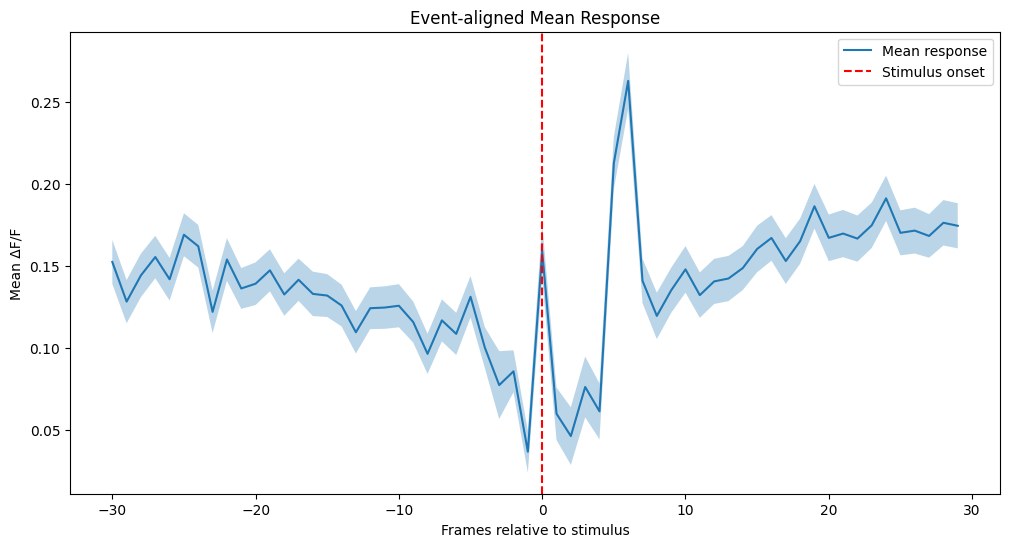

In [26]:
time = np.arange(-pre_frames, post_frames)

sem = stats.sem(aligned_data, axis=0)
mean_response = aligned_data.mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(time, mean_response, label='Mean response')
plt.fill_between(time, mean_response - sem, mean_response + sem, alpha=0.3)
plt.axvline(0, color='red', linestyle='--', label='Stimulus onset')
plt.xlabel('Frames relative to stimulus')
plt.ylabel('Mean ΔF/F')
plt.title('Event-aligned Mean Response')
plt.legend()
plt.show()

to do: 

    metadata - identify relevant metadata to pull 
    
    relate ROIs in dff to ROI masks 
    
    plot ROIs with stimulus epochs overlaid - do this programmatically pulling from tables x 
    
    PSTH/event aligned neural activity x 
    
        - opto stim x 
        
        - BCI (q: which event? motor movements?) 
        
    neural activity of each ROI organized by distance from stim neuron 
    
    nice to have: something to find connected neurons from stim periods, function to compare activity across several days 
    
    questions 